In [3]:
import modeller
from modeller import *
from modeller.scripts import complete_pdb
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
os.getcwd()

'/home/tcaceres/Documents/tecnicas_avanzadas/modelamiento/afb5'

In [3]:
# Assess DOPE

log.verbose()    # request verbose output
env = Environ()
env.libs.topology.read(file='$(LIB)/top_heav.lib') # read topology
env.libs.parameters.read(file='$(LIB)/par.lib') # read parameters

# read model pdb file

model_pdb = './modeller/AFB5.B99990038_noDegron_minimized.pdb'
mdl = complete_pdb(env, model_pdb)

# Assess with DOPE:
s = Selection(mdl)   # all atom selection
s.assess_dope(output='ENERGY_PROFILE NO_REPORT', file=model_pdb.replace('pdb', 'profile'),
              normalize_profile=True, smoothing_window=15)


                         MODELLER 10.4, 2022/10/28, r12463

     PROTEIN STRUCTURE MODELLING BY SATISFACTION OF SPATIAL RESTRAINTS


                     Copyright(c) 1989-2022 Andrej Sali
                            All Rights Reserved

                             Written by A. Sali
                               with help from
              B. Webb, M.S. Madhusudhan, M-Y. Shen, G.Q. Dong,
          M.A. Marti-Renom, N. Eswar, F. Alber, M. Topf, B. Oliva,
             A. Fiser, R. Sanchez, B. Yerkovich, A. Badretdinov,
                     F. Melo, J.P. Overington, E. Feyfant
                 University of California, San Francisco, USA
                    Rockefeller University, New York, USA
                      Harvard University, Cambridge, USA
                   Imperial Cancer Research Fund, London, UK
              Birkbeck College, University of London, London, UK


Kind, OS, HostName, Kernel, Processor: 4, Linux nothofagus 6.2.0-060200-generic x86_64
Date and time of compi

-72003.046875

In [4]:
#Modified from plot_profiles.py by Tomás Caceres <caceres.tomas@uc.cl>

#Script to write a profile csv file, which can be used to plot with Python or R

#Usage example
#python3 data_profile.py > file.log

def get_profile(profile_file):
    """Read `profile_file` into a Python array, and add gaps corresponding to
       the alignment sequence `seq`."""
    # Read all non-comment and non-blank lines from the file:
    f = open(profile_file)
    vals = []
    for line in f:
        if not line.startswith('#') and len(line) > 10:
            spl = line.split()
            vals.append(float(spl[-1]))
    return vals


profile_file = './modeller/AFB5.B99990038_noDegron_minimized.profile'

scores = get_profile(profile_file)
indexes = [x for x in range(1, len(scores) +1)]

dictionary = {
                'res': indexes,
	            'scores': scores
            }


df = pd.DataFrame(dictionary)

df.to_csv('AFB5.B99990038_noDegron_minimized.profile.csv', index=False)

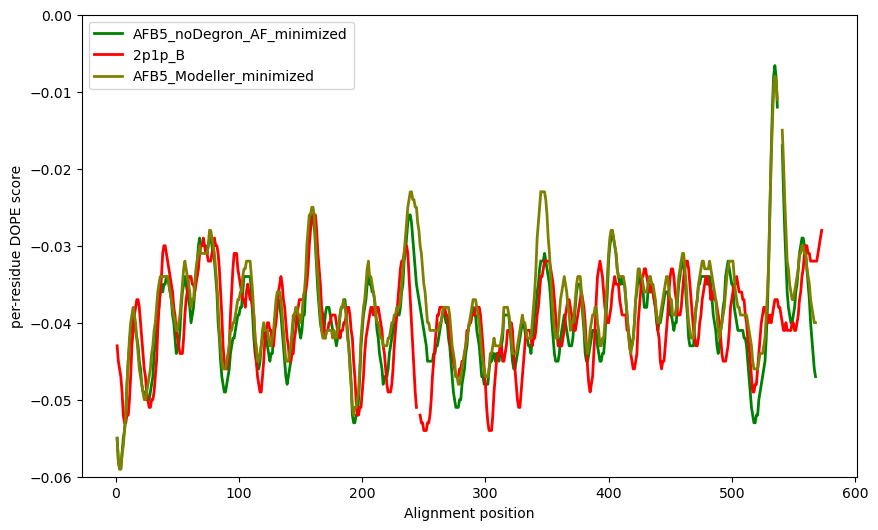

In [5]:
# Plot profiles

def r_enumerate(seq):
    """Enumerate a sequence in reverse order"""
    # Note that we don't use reversed() since Python 2.3 doesn't have it
    num = len(seq) - 1
    while num >= 0:
        yield num, seq[num]
        num -= 1

def get_profile(profile_file, seq):
    """Read `profile_file` into a Python array, and add gaps corresponding to
       the alignment sequence `seq`."""
    # Read all non-comment and non-blank lines from the file:
    f = open(profile_file)
    vals = []
    for line in f:
        if not line.startswith('#') and len(line) > 10:
            spl = line.split()
            vals.append(float(spl[-1]))
    # Insert gaps into the profile corresponding to those in seq:
    for n, res in r_enumerate(seq.residues):
        for gap in range(res.get_leading_gaps()):
            vals.insert(n, None)
    # Add a gap at position '0', so that we effectively count from 1:
    vals.insert(0, None)
    return vals



e = modeller.Environ()
# Archivo PIR con el alineamiento. Dado que ocupé la misma secuencia para MODELLER como para AF, utilizo ese mismo alineamiento
a = modeller.Alignment(e, file='./modeller/multiple_template/sin_degron/AFB5_TIR1s_modeller_input_modified.pir')

#template = get_profile('./multiple_template/degron_canonico/modelos/2p1q_B.profile', a['2p1q_B'])

# Ojo aquí. a['AFB5'] se debe mantener. El archivo .profile debe cambiarse para usar los de AF si asi se requiere
model_modeller = get_profile('./modeller/AFB5.B99990038_noDegron_minimized.profile', a['AFB5'])
model_AF = get_profile('./alphafold/AFB5_noDegron_AF_minimized.profile', a['AFB5'])
templado = get_profile('./modeller/multiple_template/degron_canonico/modelos/2p1p_B.profile', a['2p1p_B'])

# Plot the template and model profiles in the same plot for comparison:
plt.figure(1, figsize=(10,6))
plt.xlabel('Alignment position')
plt.ylabel('per-residue DOPE score')
plt.plot(model_AF, color='green', linewidth=2, label='AFB5_noDegron_AF_minimized')
plt.plot(templado, color='red', linewidth=2, label='2p1p_B')
plt.plot(model_modeller, color='olive', linewidth=2, label='AFB5_Modeller_minimized')
plt.ylim([-0.06, 0])
plt.legend()
plt.savefig('AFs vs Modeller', dpi=300)